<a href="https://colab.research.google.com/github/FunmiSomoye/School-Projects/blob/master/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asset Performance Management

Scenario: We have been given data from a Chemical Processing plant that uses its equipment for heating and cooling the chemicals that it manufactures for its customers.

We have around 5 years of data for its pump, chilling units and heat exchangers. (These individual components are not critical for our purposes.)

**Goal**: But looking at the sensors and instrumented data over 5 years of history, we have to see if the asset is performing well, or whether we are seeing anomalies.


Input file for this task: `APM_Asset_operations.csv`

### Preparatory Tasks

1. Read the input file
2. Format the data into a proper time series (with datetime) Timestamps and floats for the sensor values
3. Plot each of the sensors

### Anomaly Detection
4. Are you able to spot (visually) any anomalies?
5. Could there be threshold values that are being violated (above or below control limits?) for 'normal' operation?
5a. How to set thresholds to detect any of these anomalies.

6. (Optional): Can you try applying any of the `skelarn` outlier detection techniques? Does that catch the anomalies we say visually.

## Questions

* Focus on `Fuel Pressure`, `Lubricant Temperature` and `Tank Level`?
    * What metrics could we apply to these?
* Insights: Can we conclude that there are any alarms or anomalies in the data that we are examining?
* If you compute the rolling mean (moving averages) for these values and overlay them with the data, can you detect any anomalies?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
%matplotlib inline

## Data Prep Tasks

In [ ]:
# read data file
data_raw = pd.read_csv('APM_Asset_operations.csv', sep=',')

In [ ]:
# view data
data_raw.head(2)

,Time,Rotor_shaft_speed,Unit_Speed_RPM,Lower_shaft_speed,Line_Speed_RPM,Pressure_diff1,Pressure_diff2,Pressure_diff3,Pressure_loss,Inlet_Avg_Temp,Discharge_Avg_Temp,Discharge_Pressure,Outlet_Avg_Temp,Fuel_pressure,Lubricant_Temp,Oil_tank_level
0,1/30/13 0:00,99.9686,5098.3989,101.1093,4721.8066,77.7725,76.7162,76.3368,167.0344,22.3443,329.2889,8.8556,492.9221,19.8115,54.6645,68.6119
1,1/30/13 1:00,99.9924,5099.6123,101.5489,4742.333,78.2751,76.8406,77.2332,167.0796,22.1642,329.437,8.8732,494.634,19.7604,54.6888,68.3893


This is an hourly timeseries data

In [ ]:
# check data size
data_raw.shape

(44002, 16)

The dataset generally has 44002 rows and 16 columns

In [ ]:
# view information about column data
data_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44002 entries, 0 to 44001
Data columns (total 16 columns):
Time                  44002 non-null object
Rotor_shaft_speed     44002 non-null object
Unit_Speed_RPM        44002 non-null object
Lower_shaft_speed     44002 non-null object
Line_Speed_RPM        44002 non-null object
Pressure_diff1        44002 non-null object
Pressure_diff2        44002 non-null object
Pressure_diff3        44002 non-null object
Pressure_loss         44002 non-null object
Inlet_Avg_Temp        44002 non-null object
Discharge_Avg_Temp    44002 non-null object
Discharge_Pressure    44002 non-null object
Outlet_Avg_Temp       44002 non-null object
Fuel_pressure         44002 non-null object
Lubricant_Temp        44002 non-null object
Oil_tank_level        44002 non-null object
dtypes: object(16)
memory usage: 5.4+ MB


They are all object data types. We'll need to change 'Time' to datetime and the others to floats

In [ ]:
dm = data_raw.copy()

In [ ]:
# convert 'Time' column data type tp datetime

#data_raw['Time'] = data_raw['Time'].apply(pd.to_datetime, format='%m-%d-%Y %H:%M')  ##Code not working
dm['Time'] = pd.to_datetime(dm['Time'])

In [ ]:
#create a copy of dataframe
df = dm.copy()

In [ ]:
df.set_index('Time', inplace=True)

In [ ]:
float_cols = [col for col in df.columns if col not in ['Time']]

for col in float_cols:
    df[col] = df[col].astype('float64')

In [ ]:
#create alternate useful dataset without datetime column as index

float_cols = [col for col in dm.columns if col not in ['Time']]

for col in float_cols:
    dm[col] = dm[col].astype('float64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44002 entries, 2013-01-30 00:00:00 to 2018-02-06 09:00:00
Data columns (total 15 columns):
Rotor_shaft_speed     43221 non-null float64
Unit_Speed_RPM        43221 non-null float64
Lower_shaft_speed     43221 non-null float64
Line_Speed_RPM        43221 non-null float64
Pressure_diff1        43221 non-null float64
Pressure_diff2        43221 non-null float64
Pressure_diff3        43221 non-null float64
Pressure_loss         43221 non-null float64
Inlet_Avg_Temp        43221 non-null float64
Discharge_Avg_Temp    43221 non-null float64
Discharge_Pressure    43221 non-null float64
Outlet_Avg_Temp       43221 non-null float64
Fuel_pressure         43221 non-null float64
Lubricant_Temp        43221 non-null float64
Oil_tank_level        43221 non-null float64
dtypes: float64(15)
memory usage: 6.6 MB


Clearly from the above, there are missing values

#### Plot

Text(0.5, 1.0, 'Sensor Readings')

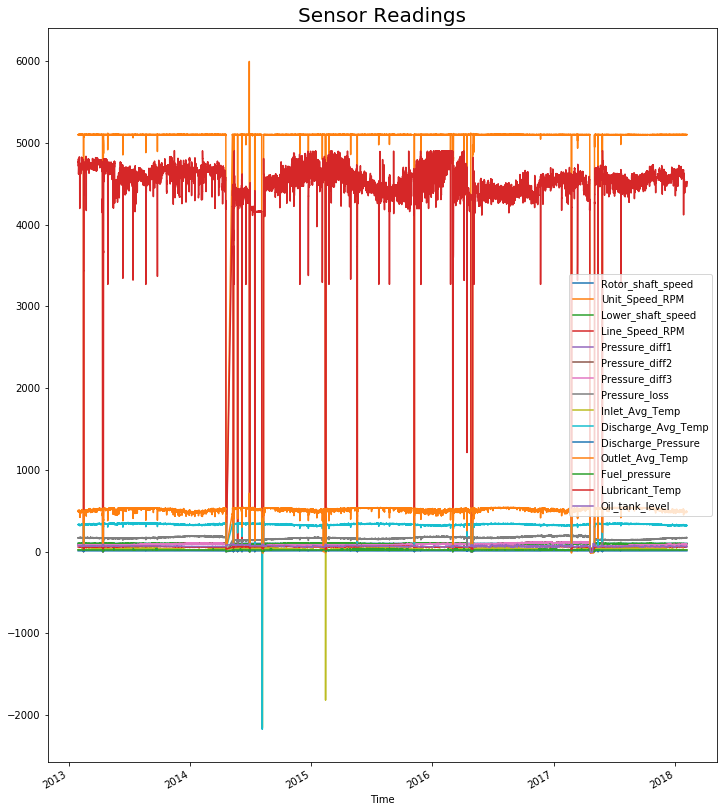

In [ ]:
df.dropna().plot(figsize=(12, 15))
plt.title('Sensor Readings', fontsize=20)

The plot above comparing the sensor readings on the sample sclae on the yaxis shows that the Line_Speed_RPM, and the Unit_Speed_RPM have significantly higher values of readings than the rest of the sensors.

The long lines are clear indicators of anomalies within some of the sensor data. There is also an are of missing values around the 2014 timeline.

## Anomaly Detection Tasks

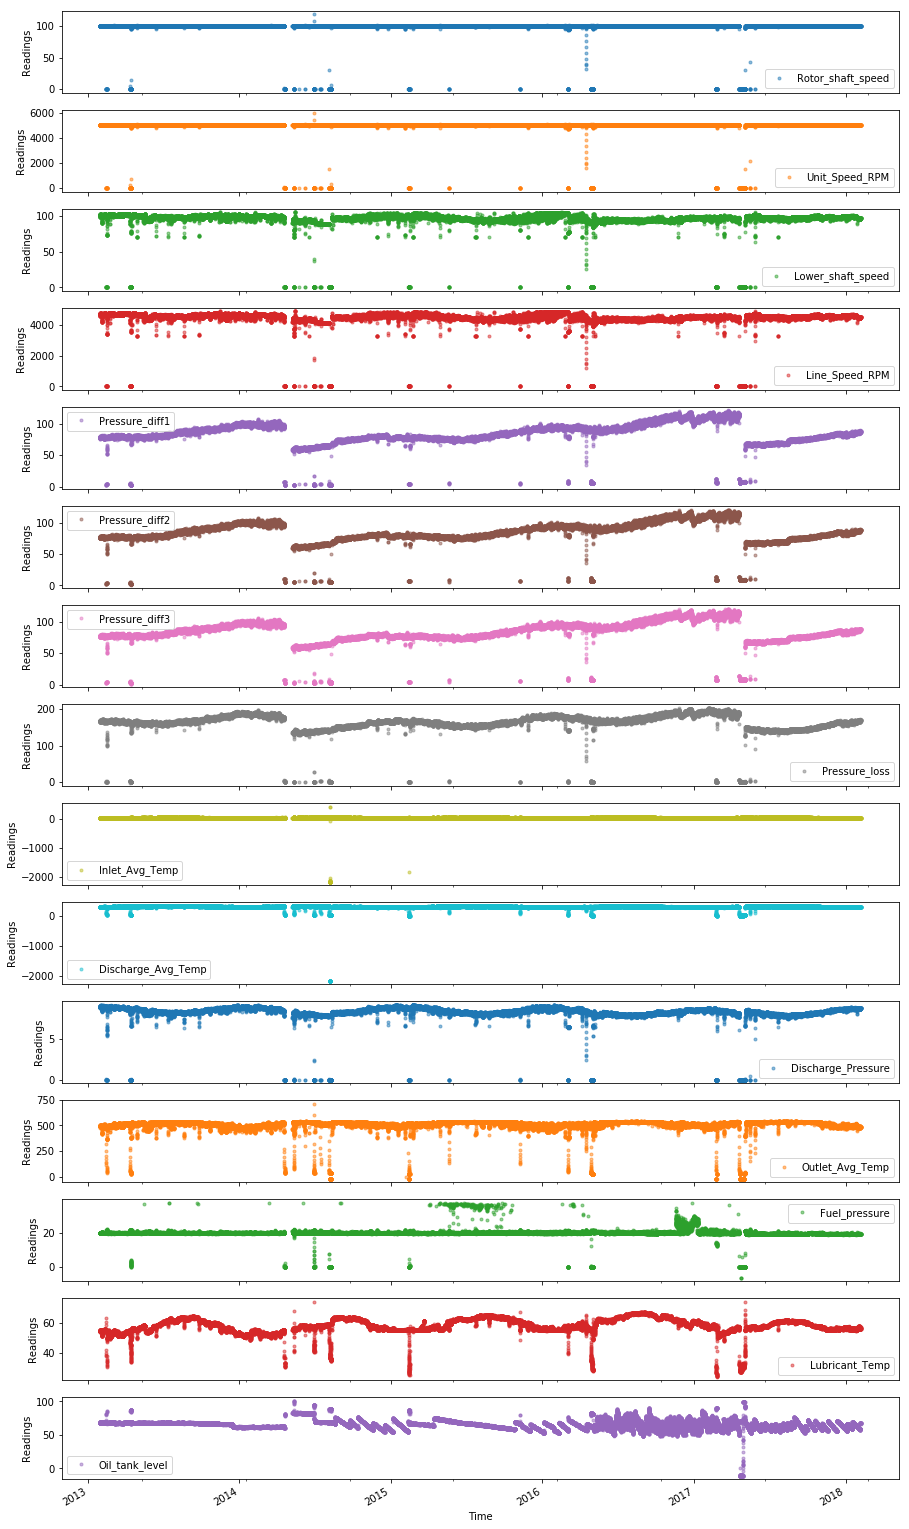

In [ ]:
#Plot sensors
cols_plot = [col for col in df.columns]

axes = df[cols_plot].plot(marker='.', linestyle='None', alpha=0.5, figsize=(15, 30), subplots=True)
for ax in axes:
    ax.set_ylabel('Readings')

From the plots above, the major area with missing value is even clearer, as well as the various anomalies within each dataset.
Definitely, there are values that are abnormalies from the normal operatig thresholds.

In [ ]:
#### Threshold

In [ ]:
#see data distribution through statistical analysis
df.describe()

,Rotor_shaft_speed,Unit_Speed_RPM,Lower_shaft_speed,Line_Speed_RPM,Pressure_diff1,Pressure_diff2,Pressure_diff3,Pressure_loss,Inlet_Avg_Temp,Discharge_Avg_Temp,Discharge_Pressure,Outlet_Avg_Temp,Fuel_pressure,Lubricant_Temp,Oil_tank_level
count,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000,43221.000000
mean,97.830478,4989.337729,95.291390,4450.134480,83.894532,84.841734,83.562924,162.851943,28.407816,324.235848,8.157538,503.345469,19.724214,58.145364,65.543950
std,14.498846,739.439577,14.585365,681.110783,17.227659,17.277755,17.306860,28.214568,66.400100,71.969237,1.260595,73.211505,2.938076,5.015666,7.904904
min,0.000000,0.000000,0.000000,0.000000,2.832500,1.532600,1.681700,-0.368200,-2154.054400,-2171.644000,-0.003400,-17.777800,-6.248400,24.452700,-10.796300
25%,99.990700,5099.483900,95.149000,4443.404300,76.506100,77.329100,75.865100,155.669100,24.642800,324.721900,8.060700,499.082100,19.727400,55.566900,61.680400
50%,99.999300,5099.959500,97.672600,4561.355000,82.341000,83.008900,81.911300,165.844400,31.385100,332.444900,8.307200,517.080900,19.843700,57.861600,66.071100
75%,100.008400,5100.423300,99.601300,4651.378900,93.829000,95.099200,94.118400,177.355300,35.912200,337.670000,8.628900,532.153900,19.969700,61.692500,68.425200
max,117.561200,5995.623000,105.021900,4904.525400,120.528000,121.905400,121.169400,204.849700,411.426100,367.229500,9.143700,713.018500,37.511100,73.928700,101.148500


Text(0.5, 1.0, 'Sensor Data Distribution')

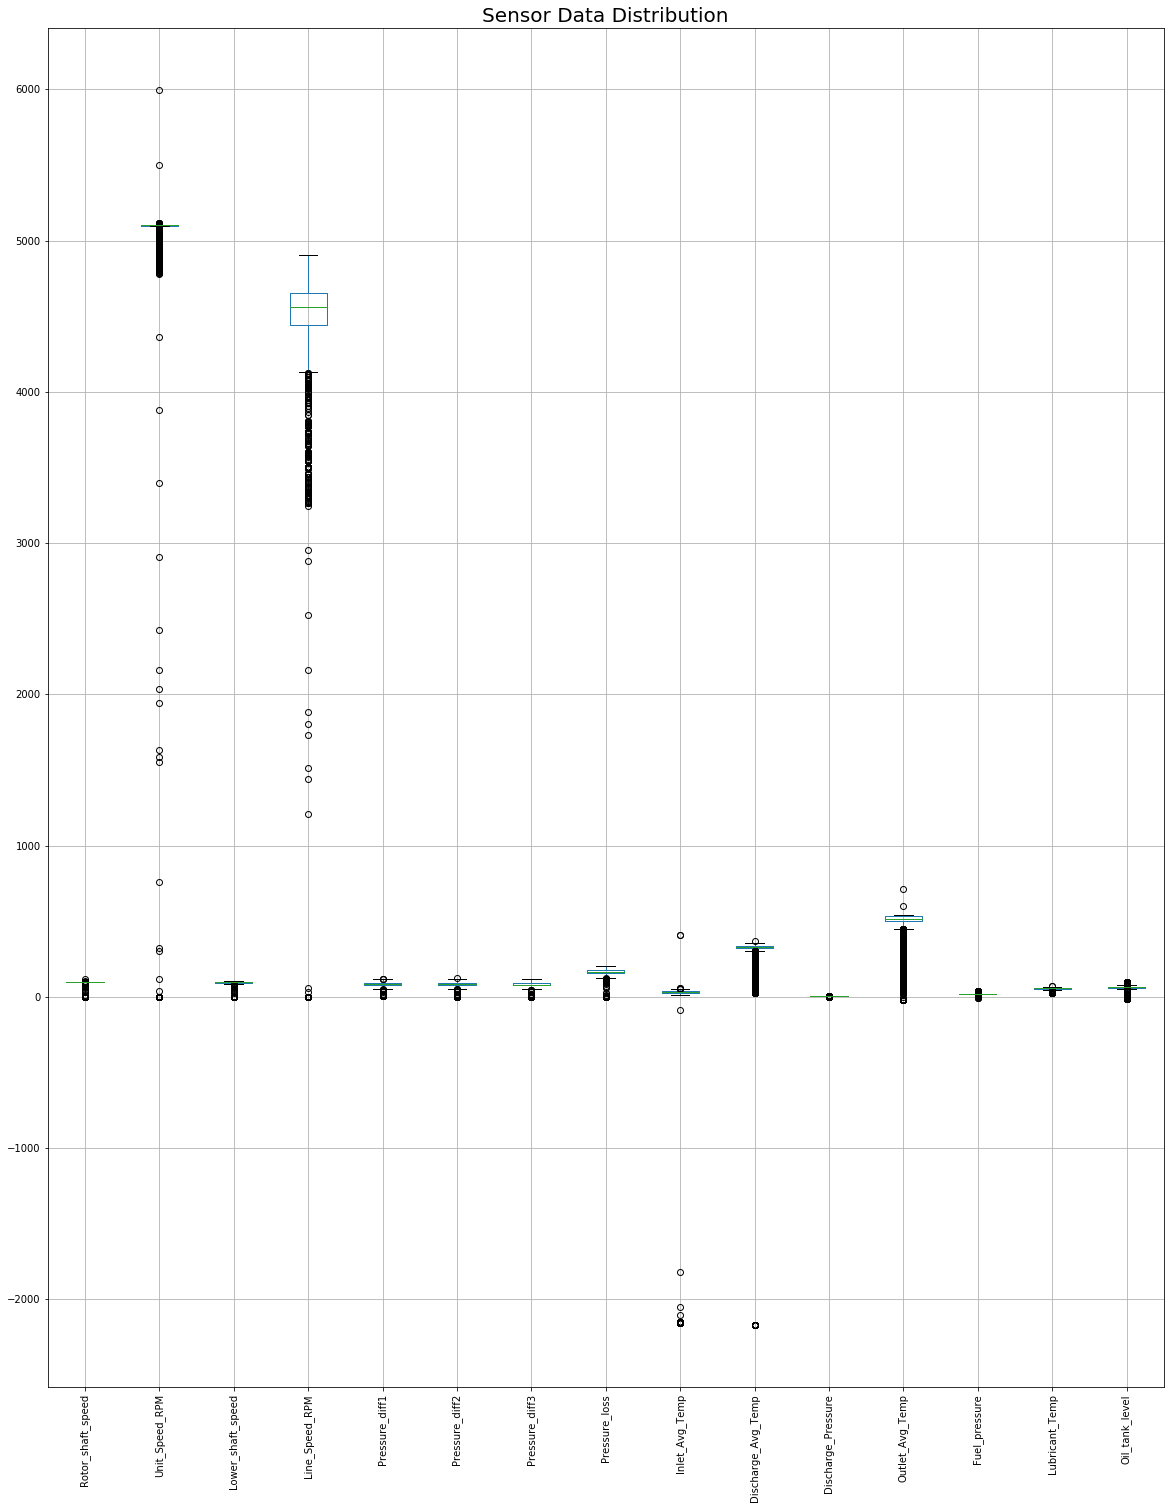

In [ ]:
#Plot boxplot for better view of data distribution
#plt.title('Sensor Readings', fontsize=20)

boxplot = df.plot.box(figsize=(20,25))
plt.grid(True)

boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

plt.title('Sensor Data Distribution', fontsize=20)

In [ ]:
#fig = plt.figure(figsize=(25, 10))
#sns.set(style="whitegrid")
#sns.boxplot(data=df, orient='h')
#plt.title('Sensor Data Distribution', size = 15)

Considering that this is a timeseries data, one has to exercise extreme caution.

One easy way to set thresholds would be to observe the upper and lower limits of the boxplot whiskers, and set upper and lower limit filters using them as references. 

Another way would be creating a function to calculate the zscore for each sensor, or the Interquartile range.

Also, another way would be to use the Sliding window forecasting method.

The Isolation Forest algorithm from the Sklearn library can also be used to detect outliers here.

##### Using Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [ ]:
X = df[['Fuel_pressure']].dropna()

In [ ]:
#split test and train, and stratify using drive status; whether failed, or still healthy
X_train, X_test = train_test_split(X, test_size=0.3)

In [ ]:
# fit the model
clf = IsolationForest(max_samples=30254)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

C:\Users\acer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\acer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\acer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:250: UserWarning: max_samples (43221) is greater than the total number of samples (30254). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
C:\Users\acer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\acer\Anaco

In [ ]:

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 15127), np.linspace(-5, 5, 15127))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

In [ ]:

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

#### Fuel Pressure, Lubricant Temperature, and Oil Tank Level

In [ ]:
data_t = dm[['Time','Fuel_pressure', 'Lubricant_Temp', 'Oil_tank_level']]

In [ ]:
data_t.head(1)

,Time,Fuel_pressure,Lubricant_Temp,Oil_tank_level
0,2013-01-30,19.8115,54.6645,68.6119


In [ ]:
new_data = df[['Fuel_pressure', 'Lubricant_Temp', 'Oil_tank_level']]

In [ ]:
new_data.head(25)

,Fuel_pressure,Lubricant_Temp,Oil_tank_level
Time,,,
2013-01-30 00:00:00,19.8115,54.6645,68.6119
2013-01-30 01:00:00,19.7604,54.6888,68.3893
2013-01-30 02:00:00,19.7733,54.7309,68.3634
2013-01-30 03:00:00,19.7667,54.6808,68.2874
2013-01-30 04:00:00,19.7841,54.5959,68.4671
2013-01-30 05:00:00,19.7496,54.6479,68.2203
2013-01-30 06:00:00,19.7626,54.6275,68.3653
2013-01-30 07:00:00,19.7518,54.8121,68.4082
2013-01-30 08:00:00,19.7052,55.0199,68.2695


In [ ]:
#see data distribution through statistical analysis
new_data.describe()

,Fuel_pressure,Lubricant_Temp,Oil_tank_level
count,43221.000000,43221.000000,43221.000000
mean,19.724214,58.145364,65.543950
std,2.938076,5.015666,7.904904
min,-6.248400,24.452700,-10.796300
25%,19.727400,55.566900,61.680400
50%,19.843700,57.861600,66.071100
75%,19.969700,61.692500,68.425200
max,37.511100,73.928700,101.148500


Text(0.5, 1.0, 'Sensor Data Distribution')

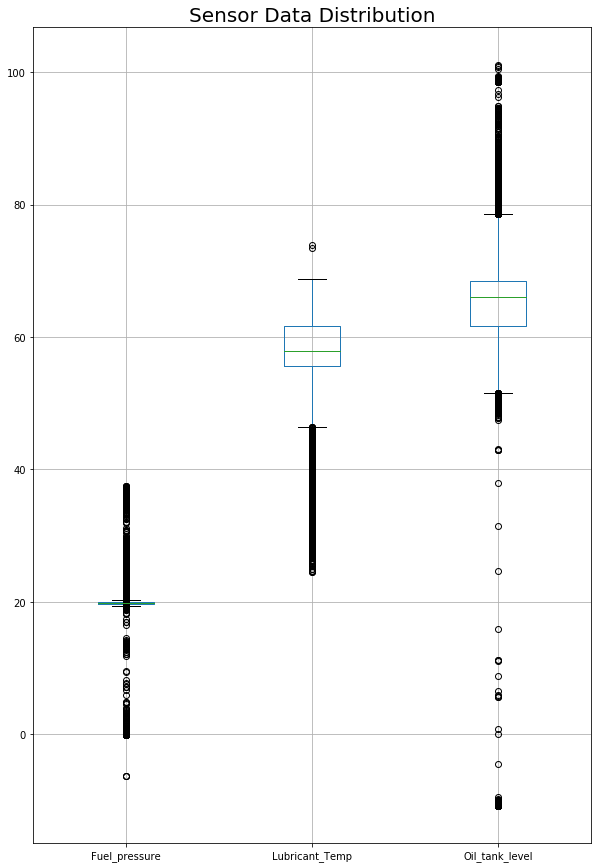

In [ ]:
#create a boxplot
new_data.plot.box(figsize=(10,15))
plt.grid(True)
plt.title('Sensor Data Distribution', fontsize=20)

There are certainly anomalies in these data

In [ ]:
new_data.describe()

,Fuel_pressure,Lubricant_Temp,Oil_tank_level
count,43221.000000,43221.000000,43221.000000
mean,19.724214,58.145364,65.543950
std,2.938076,5.015666,7.904904
min,-6.248400,24.452700,-10.796300
25%,19.727400,55.566900,61.680400
50%,19.843700,57.861600,66.071100
75%,19.969700,61.692500,68.425200
max,37.511100,73.928700,101.148500


For the data above, we can apply the following metrics:
    
    How many times a machine should be serviced per month
    Average frequency of oil top-up over a certain period
    Average frequency for Lubricant change
    How much Lubricant to be used by a machine over a period
    Number of needed downtimes for scheduled maintenance in a year
    Frequency of Fuel pressure regulator change over a period
    Average cost of maintenance over a period

##### Moving Average

In [ ]:
#observe data for trend or seasonality to help decide size of rolling window 

Text(0.5, 1.0, 'Sensor Readings')

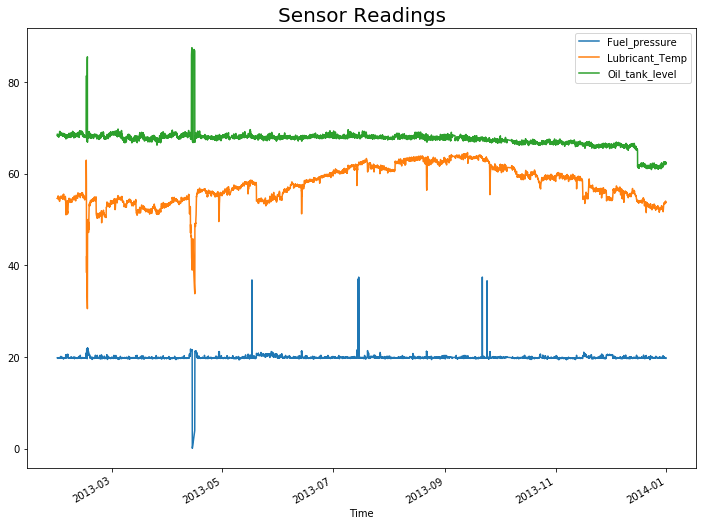

In [ ]:
new_data['2013'].dropna().plot(figsize=(12, 9))
plt.title('Sensor Readings', fontsize=20)

Text(0.5, 1.0, 'March Sensor Readings')

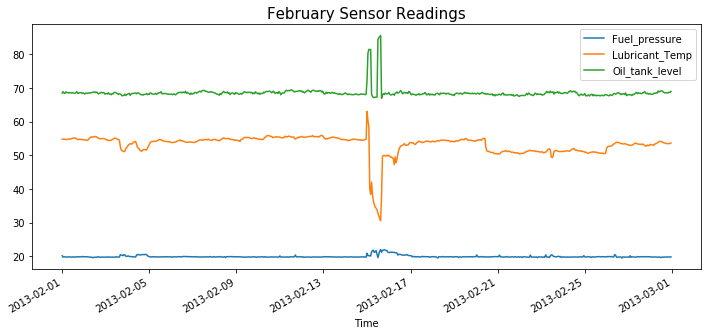

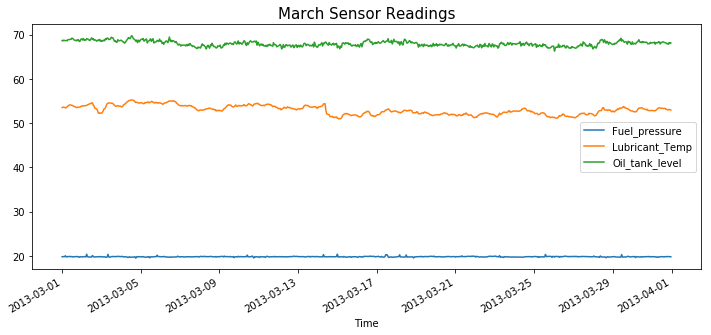

In [ ]:
feb_2013 = new_data.loc['2013-2-1 00:00:00':'2013-2-28 23:00:00']
mar_2013 = new_data.loc['2013-3-1 00:00:00':'2013-3-31 23:00:00']


feb_2013.dropna().plot(figsize=(12, 5))
plt.title('February Sensor Readings', fontsize=15)

mar_2013.dropna().plot(figsize=(12, 5))
plt.title('March Sensor Readings', fontsize=15)

I do not observe trend or seasonality from the above

In [ ]:
#Calculate rolling means

In [ ]:
###### Simple Moving Average
#(Remember to use large figures)

In [ ]:
new_data[["sma200_FP", "sma200_LT", "sma200_OTL"]] = new_data.rolling(window=200).mean()

In [ ]:
new_data[["sma100_FP", "sma100_LT", "sma100_OTL"]] = new_data[["Fuel_pressure", "Lubricant_Temp", "Oil_tank_level"]].rolling(window=100).mean()

In [ ]:
###### Exponential Moving Average

In [ ]:
new_data[["ewm30_FP", "ewm30_LT", "ewm30_OTL"]] = new_data[["Fuel_pressure", "Lubricant_Temp", "Oil_tank_level"]].ewm(span=30, adjust=True).mean()

In [ ]:
new_data[["ewm10_FP", "ewm10_LT", "ewm10_OTL"]] = new_data[["Fuel_pressure", "Lubricant_Temp", "Oil_tank_level"]].ewm(span=10, adjust=True).mean()

Text(0.5, 1.0, 'Fuel Pressure Sensor')

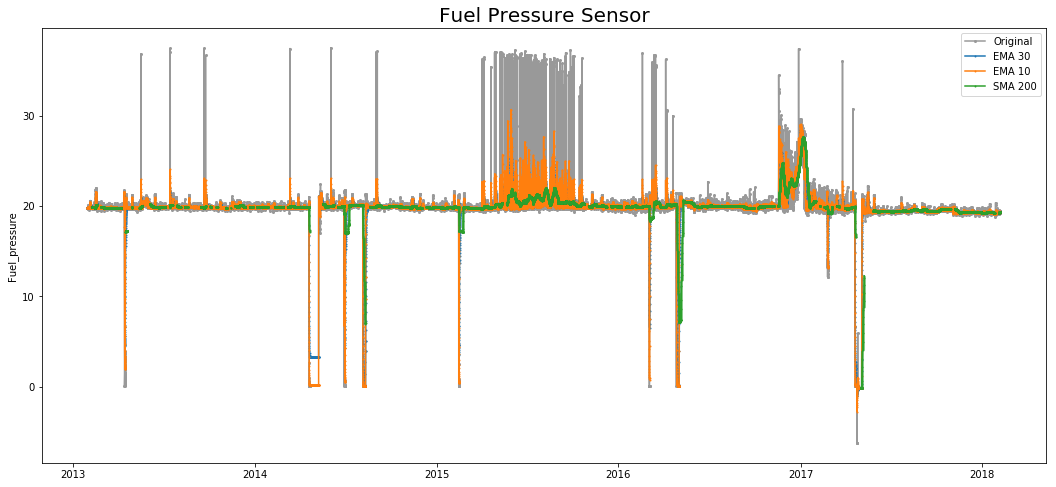

In [ ]:
#visualise Temp1 on 3 downsamplings

fig, ax = plt.subplots(figsize=(18,8))

ax.plot(new_data["Fuel_pressure"], marker='o', markersize=2, color='0.6', linestyle='-', label='Original') 

ax.plot(new_data["ewm30_FP"], marker='.', markersize=2, linestyle=None, label='EMA 30') 
ax.plot(new_data["ewm10_FP"], marker='.', markersize=2, linestyle=None, label='EMA 10') 
ax.plot(new_data["sma200_FP"], marker='.', markersize=2, linestyle=None, label='SMA 200')
#ax.plot(new_data["sma100_FP"], marker='.', markersize=2, linestyle='-', label='SMA 100')

ax.set_ylabel('Fuel_pressure')
ax.legend()
plt.title('Fuel Pressure Sensor', size=20)

The moving average pplot, and that of the original data are very similar, and follow the same pattern.

I'll plot another graph to get a closer look

In [ ]:
##### Monthly Data

In [ ]:
feb_2013[["sma200_FP", "sma200_LT", "sma200_OTL"]] = feb_2013.rolling(window=200).mean()

In [ ]:
feb_2013[["ewm10_FP", "ewm10_LT", "ewm10_OTL"]] = feb_2013[["Fuel_pressure", "Lubricant_Temp", "Oil_tank_level"]].ewm(span=10, adjust=True).mean()

Text(0.5, 1.0, 'Fuel Pressure Sensor February 2013')

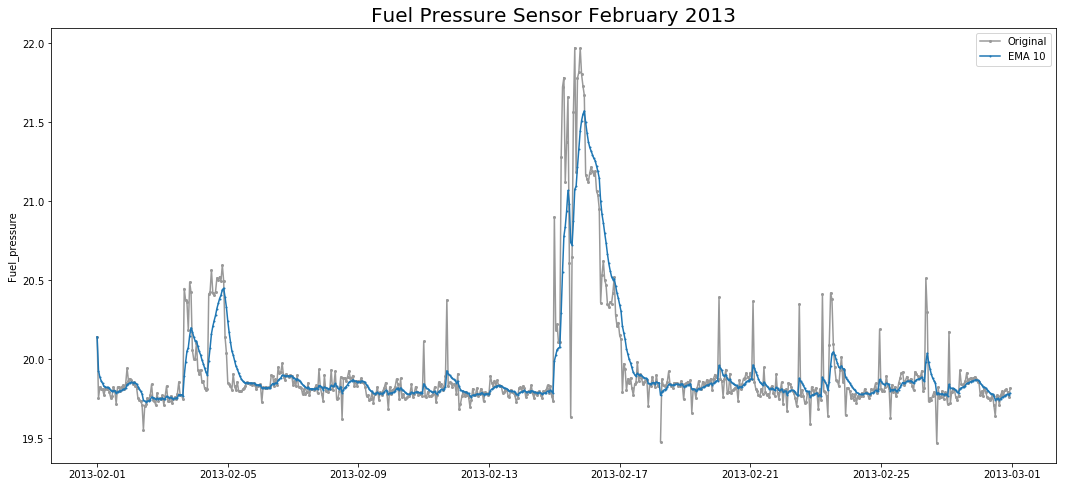

In [ ]:
#visualise Temp1 on 3 downsamplings

fig, ax = plt.subplots(figsize=(18,8))

ax.plot(feb_2013["Fuel_pressure"], marker='o', markersize=2, color='0.6', linestyle='-', label='Original') 
ax.plot(feb_2013["ewm10_FP"], marker='.', markersize=2, linestyle=None, label='EMA 10') 

ax.set_ylabel('Fuel_pressure')
ax.legend()
plt.title('Fuel Pressure Sensor February 2013', size=20)

Perhaps, the above plot does reveal possible anomalies

# Conclusions and Recommendations

In [ ]:
feb_2013.loc['2013-2-13 00:00:00':'2013-2-15 23:00:00']

,Fuel_pressure,Lubricant_Temp,Oil_tank_level,sma200_FP,sma200_LT,sma200_OTL,ewm10_FP,ewm10_LT,ewm10_OTL
Time,,,,,,,,,
2013-02-13 00:00:00,19.7881,55.5137,68.4830,19.841803,54.706489,68.608090,19.781546,55.647718,68.938060
2013-02-13 01:00:00,19.8949,55.0335,68.1694,19.838759,54.723507,68.609679,19.802156,55.536042,68.798303
2013-02-13 02:00:00,19.8526,54.8337,68.3225,19.835409,54.739036,68.610830,19.811328,55.408344,68.711794
2013-02-13 03:00:00,19.8324,55.0170,68.7418,19.832086,54.755651,68.614338,19.815159,55.337190,68.717249
2013-02-13 04:00:00,19.8650,54.8445,68.3650,19.828434,54.771975,68.615747,19.824221,55.247610,68.653204
2013-02-13 05:00:00,19.8329,54.9554,68.6123,19.825124,54.788966,68.617123,19.825799,55.194481,68.645767
2013-02-13 06:00:00,19.8670,55.0718,68.6130,19.823757,54.803987,68.620156,19.833290,55.172175,68.639809
2013-02-13 07:00:00,19.8355,55.1695,68.4412,19.822725,54.816692,68.621266,19.833692,55.171689,68.603699
2013-02-13 08:00:00,19.8306,55.2453,68.3988,19.822616,54.826634,68.622840,19.833130,55.185073,68.566444


This is definitely a complex system. From the data above, an increase in the Fuel Pressure had a significant effect on the Lubricant Temperature and the Oil level in the tank. 

This may mean that the machine is working quite well, since there is a significant response from the other machine parts, to the increase in fuel pressure.